## Long term memory - sqlite

In [1]:
from Langgraph.configs import API_KEY, DEFAULT_MODEL
import os
import openai
from langgraph.graph import START, END, StateGraph, MessagesState
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage, SystemMessage, RemoveMessage
from langgraph.checkpoint.memory import InMemorySaver
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

In [2]:
os.environ["OPENAI_API_KEY"] = API_KEY
openai.api_key = os.getenv('OPENAI_API_KEY')

In [3]:
class State(MessagesState):
    summary: str

chat = ChatOpenAI(model='gpt-4',
                 seed = 365,
                 temperature = 0,
                 max_completion_tokens = 100)

In [4]:
def ask_question(state: State) -> State:
    print("\n--------------> Entering Ask Question Node:")
    question = "What is your question?"
    print(question)
    return State(messages=[AIMessage(question), HumanMessage(input())])

def chatbot(state: State) -> State:
    print("\n--------------> Entering Chatbot:")
    for i in state["messages"]:
        i.pretty_print()

    system_message = f"""
    Here is a quick summary of what's been discussed so far:
    {state.get("summary","")}
    Keep this in mind as you answer the next question.
    """
    
    response = chat.invoke([SystemMessage(system_message)] + state['messages'])
    response.pretty_print()
    return State(messages=[response])

def summarize_and_delete_messages(state: State) -> State:
    print("\n--------------> Entering summarization Node:")
    new_conversation = ""
    for i in state["messages"]:
        new_conversation += f"{i.type}: {i.content}\n\n"
        
    summary_instructions = f"""
    Update the ongoing summary by incorporating new lines of the conversation below.
    Build upon the previous summary rather than repeating it so that the result
    reflects the most recent context and developments.

    Previous summary:
    {state.get("summary","")}

    New Conversation:
    {new_conversation}
    """

    print(summary_instructions)

    summary = chat.invoke([HumanMessage(summary_instructions)])
    
    remove_messages = [RemoveMessage(i.id) for i in state["messages"][:]]
    
    return State(messages = remove_messages, summary = summary.content)

In [5]:
graph_ms = StateGraph(MessagesState)
graph_ms.add_node("ask_question", ask_question)
graph_ms.add_node("chatbot", chatbot)
# graph_ms.add_node("ask_another_question", ask_another_question)
graph_ms.add_node("summarize_and_delete_messages", summarize_and_delete_messages)

graph_ms.add_edge(START, "ask_question")
graph_ms.add_edge("ask_question", "chatbot")
graph_ms.add_edge("chatbot", "summarize_and_delete_messages")
# graph_ms.add_conditional_edges(source = "ask_another_question", 
                            # path = routing_function,)
graph_ms.add_edge("summarize_and_delete_messages", END)

In [6]:
db_path = "D:/Projects/pyspark/nlp_course/Langgraph/langgraph.db"
conn = sqlite3.connect(database = db_path, check_same_thread = False)

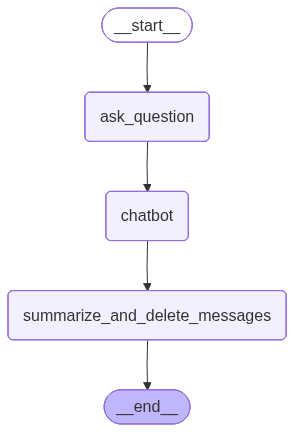

In [7]:
checkpointer = SqliteSaver(conn)
graph_ms_compiled = graph_ms.compile(checkpointer)
graph_ms_compiled

In [8]:
config1 = {"configurable": {"thread_id": "1"}}
config2 = {"configurable": {"thread_id": "2"}}

In [9]:
graph_ms_compiled.invoke(State(), config1)


--------------> Entering Ask Question Node:
What is your question?


 where was he born?



--------------> Entering Chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

where was he born?
================================== Ai Message ==================================

Guido van Rossum was born in Haarlem, Netherlands.

--------------> Entering summarization Node:

    Update the ongoing summary by incorporating new lines of the conversation below.
    Build upon the previous summary rather than repeating it so that the result
    reflects the most recent context and developments.

    Previous summary:
    The AI informed the human that the developer of the Python language is Guido van Rossum.

    New Conversation:
    ai: What is your question?

human: where was he born?

ai: Guido van Rossum was born in Haarlem, Netherlands.


    


{'messages': []}